# Best Buy Project Week - EDA Notebook
##  - Sound of Magic

### Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

#Time Series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

#Boosting Trees
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lbr
from xgboost import XGBRegressor as xgb

#Helper Functions
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

#Plotting
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import seaborn as sns
plt.style.use('ggplot')

#Hyper Parameter Tuning
import optuna

#Utils functions
from utils import *

#### Data load

First we load both and train and validation datasets given as the base datasets for training and prediction respectively.

In [2]:
def loadTrainData():
    data=pd.read_excel("data/Hackathon Data.xlsx",engine='openpyxl')
    data = data[~data.Encoded_SKU_ID.isna()]
    data = data[[i for i in data.columns if "Unnamed" not in i]]
    print("Shape of Train Dataset: ", data.shape)
    display(data.head())
    return data

data = loadTrainData()

Shape of Train Dataset:  (846632, 11)


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS
0,1.0,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1.0
1,2.0,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18.0
2,3.0,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7.0
3,4.0,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6.0
4,1.0,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7.0


In [3]:
def loadValidationData():
    val=pd.read_excel("data/Validation_Data.xlsx",engine='openpyxl')
    val = val[~val.Encoded_SKU_ID.isna()]
    val = val[[i for i in val.columns if "Unnamed" not in i]]
    print("Shape of Validation Dataset: ", val.shape)
    display(val.head())
    return val

val = loadValidationData()

Shape of Validation Dataset:  (3773, 12)


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS,Forecasted Units
0,23.0,2022-08-06,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Moderate,3.0,NaN
1,100.0,2022-08-02,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,16.99,Fully-Stocked,2.0,NaN
2,121.0,2022-08-06,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,24.99,?,?,Fully-Stocked,6.0,NaN
3,207.0,2022-08-03,OTR MIC,OTR MICROWAVE,ML - Kitchen,VP - Major Appliances,499.99,?,?,Fully-Stocked,0.0,NaN
4,416.0,2022-08-05,AMPS,CAR STEREO,ML - Connected Car,VP - Electrify & Car,269.99,?,?,Fully-Stocked,9.0,NaN


Combine Train and Validation for cleaning and exploration.

In [4]:
df = pd.concat([data,val])

#### Clean, Process and perform feature engineering on data

Refer to function documentation for detailed explanation.

In [ ]:
df = cleanData(df)
df.head()

### Feature Engineering

#### Time Series

We explore acf and pacf plot of a SKUs to guage their AR and MA order values. Overall majority of the products tested follow AR(1) process.
Hence, we use daily units sold values of the previous feature for predicting the current day's sales in future boosting tree models.

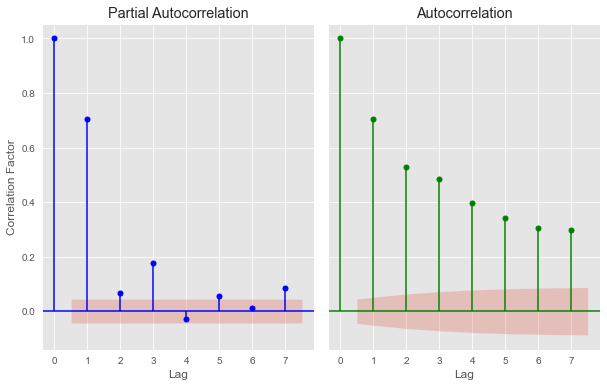

In [89]:
dfs = df[df.encoded_sku_id==97].copy()

fig,ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
plt.subplots_adjust(wspace=0.05)
tsaplots.plot_pacf(dfs["daily_units"], lags=7, ax=ax[0], color = "blue", vlines_kwargs={"colors": "blue"})
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Correlation Factor")
tsaplots.plot_acf(dfs["daily_units"], lags=7, ax=ax[1], color = "green", vlines_kwargs={"colors": "green"})
ax[1].set_xlabel("Lag")
plt.savefig("images/time_series.png")

### STL decomposition at SKU Level

As daily units for each sku follows a time series, we decomposed it on STL across the date range.
Further, we use the trend values as a feature.

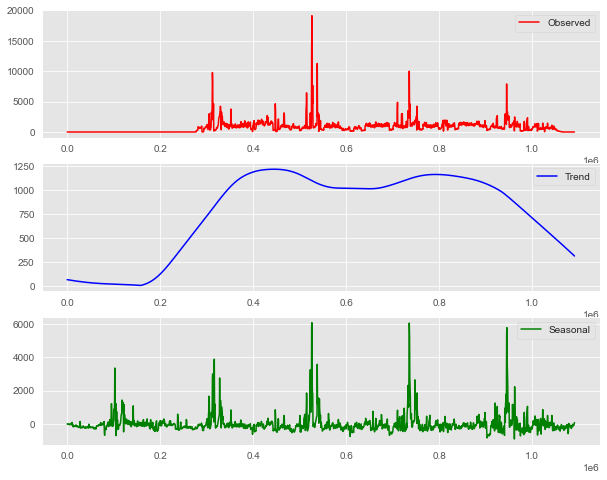

In [90]:
res = STL(dfs["daily_units"], period=365).fit()
trend = res.trend
dfs["trend"] = (trend-trend.mean())/trend.std()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
plt.subplots_adjust(wspace=0.05)

# plot the observed time series data
ax1.plot(dfs["daily_units"], label='Observed', color = "red")
ax1.legend()

# plot the trend component
ax2.plot(res.trend, label='Trend', color = "blue")
ax2.legend()

# plot the seasonal component
ax3.plot(res.seasonal, label='Seasonal', color = "green")
ax3.legend()

# show the plot
plt.savefig("images/stl.png")

## Modelling

#### Train and Test Time Series Splits

Data is time series, hence we cannot shuffle or look ahead when predicting sales. Towards this, we create 10 time series splits for cross validation, etc.
The train splits grow at about 180 days and the test size is always 7 days post the last training sample.

In [94]:
def createTrTs(df, splits=10, test_size=7):
    dates = np.array(sorted(df.sales_date.unique()))
    test = dates[-test_size:]
    dates = dates[:-test_size]
    trains = np.array_split(dates,splits)
    tests = [i[:test_size] for i in trains[1:]] + [test]
    return trains, tests

def generateTimeSeriesSplits(trains, tests, df):
    for i, ts in enumerate(tests):
        tr = np.concatenate(trains[:i+1])
        tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(ts)].copy()
        yield tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

trains, tests = createTrTs(df)

#### Optimal Models

Using Optuna we tuned the model hyper parameters and are using them directly. We trained 2 model,

* Daily Forecast: We continuously forecast daily the next day's expected sales
* Weekly Forecast: Forecast is done for an entire week with "units_lag1"

In [135]:
def forecast1DayTuned():
    tr = np.concatenate(trains)
    tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(tests[-1])].copy()
    tr,ts = tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

    params = {'max_depth': 4,
     'lambda_l1': 0.29719719373159487,
     'lambda_l2': 0.11176965177998135,
     'num_leaves': 8}

    reg = lbr(**params)

    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    reg.fit(xtr,ytr)
    ts_pred = ts.copy()
    ts_pred["daily_units"] = reg.predict(ts.drop("daily_units",axis=1))

    print("RMSE value for test period: ", mean_squared_error(ts["daily_units"], ts_pred["daily_units"], squared=False))
    return reg, tr, ts, ts_pred

res0 = forecast1DayTuned()

[LightGBM] [Warning] lambda_l1 is set=0.29719719373159487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29719719373159487
[LightGBM] [Warning] lambda_l2 is set=0.11176965177998135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11176965177998135
RMSE value for test period:  2.88584408572453


In [140]:

reg, tr, ts, pred = res0
ts["forecasted units"] = pred["daily_units"].values
def safeRMSE(x):
    return pd.Series({
        "RMSE": mean_squared_error(x["daily_units"], x["forecasted units"], squared=False)
    })

df1 = ts.groupby("sales_date").apply(safeRMSE).sort_values("RMSE")

In [143]:
def forecast7DaysTuned():
    tr = np.concatenate(trains)
    tr,ts = df[df.sales_date.isin(tr)].copy(), df[df.sales_date.isin(tests[-1])].copy()
    tr,ts = tr.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True),ts.sort_values(["encoded_sku_id","sales_date"]).reset_index(drop=True)

    params = {
        'max_depth': 3,
        'lambda_l1': 0.2045319465453519,
        'lambda_l2': 0.4200809674677322,
        'num_leaves': 7
    }
    reg = lbr(**params)

    xtr,ytr = tr.drop("daily_units", axis=1), tr["daily_units"]
    reg.fit(xtr,ytr)

    def moving_fill(x): # Use forcast to create lag values
        temp = tr[tr['encoded_sku_id']==x['encoded_sku_id'].iloc[0]].reset_index(drop=True)
        x = x.reset_index(drop=True)
        for i in range(x.shape[0]):
            prev = temp["daily_units"].iloc[-1] if temp.shape[0]>0 else np.nan
            x.loc[i,"units_lag1"] = x.loc[i-1, "daily_units"] if i>0 else prev
            x.loc[i,'daily_units'] = reg.predict(x.drop(['daily_units'],axis=1).iloc[i:i+1,:])
        return x

    ts_pred = ts.groupby('encoded_sku_id', as_index=False).apply(moving_fill)
    print("RMSE value for test period: ", mean_squared_error(ts["daily_units"], ts_pred["daily_units"], squared=False))
    return reg, tr, ts, ts_pred

res1 = forecast7DaysTuned()

[LightGBM] [Warning] lambda_l1 is set=0.2045319465453519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2045319465453519
[LightGBM] [Warning] lambda_l2 is set=0.4200809674677322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4200809674677322
RMSE value for test period:  3.53411289691875


In [156]:
reg, tr, ts, ts_pred = res1
ts["forecasted units"] = ts_pred["daily_units"].values
def safeRMSE(x):
    return pd.Series({
        "RMSE": mean_squared_error(x["daily_units"], x["forecasted units"], squared=False),
        "Mean" : x["daily_units"].mean()}
    )


df2 = ts.groupby("sales_date").apply(safeRMSE).sort_values("RMSE")

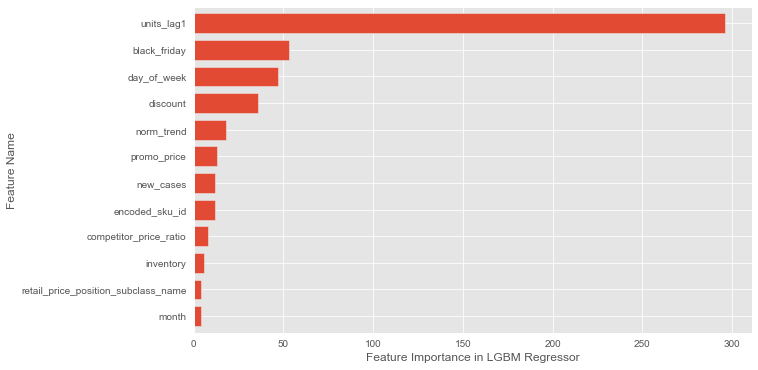

In [183]:
x = pd.DataFrame(reg.feature_importances_ , index= tr.drop("daily_units", axis=1).columns.tolist(), columns = ["feature_imp"]).sort_values("feature_imp", ascending = False)["feature_imp"]
x = x[x>3]
fig, ax = plt.subplots(1,1,figsize=(10,6))
x.sort_values().plot.barh(width=0.75, ax=ax)
ax.set_xlabel("Feature Importance in LGBM Regressor")
ax.set_ylabel("Feature Name")
plt.savefig("images/feature_imp.png")

In [154]:
df1

,RMSE
sales_date,
1.659398e+09,2.154800
1.659571e+09,2.222029
1.659658e+09,2.404525
1.659485e+09,2.862051
1.659312e+09,3.132513
1.659830e+09,3.222427
1.659744e+09,3.813969


In [157]:
df2

,RMSE,Mean
sales_date,,
1.659571e+09,2.372581,3.270872
1.659398e+09,2.395817,3.200371
1.659485e+09,2.762950,3.129870
1.659658e+09,3.067889,3.714286
1.659312e+09,3.218958,3.204082
1.659830e+09,4.149747,3.371058
1.659744e+09,5.606485,4.419295


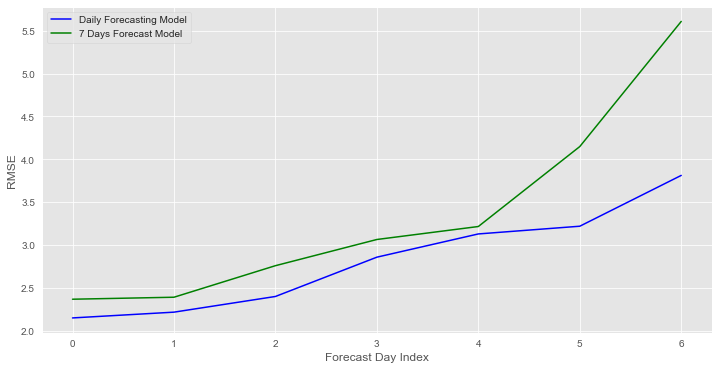

In [164]:
fig, ax = plt.subplots(1,1,figsize = (12,6))
ax.plot(df1["RMSE"].values, color = "blue", label = "Daily Forecasting Model")
ax.plot(df2["RMSE"].values, color = "green", label = "7 Days Forecast Model")
ax.set_xlabel("Forecast Day Index")
ax.set_ylabel("RMSE")
ax.legend()
plt.savefig("images/model_daily_rmse.png")

In [109]:
pred

,sales_date,encoded_sku_id,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,...,year,day_of_week,competitor_price_ratio,discount,black_friday,retail_price_position_subclass_name,retail_price_position_class_name,retail_price_position_ml_name,retail_price_position_category_name,units_lag1
0,1.659312e+09,1.0,43,7,1,0,89.99,NaN,NaN,1,...,2022,0,NaN,NaN,0.0,1.306943,1.050779,1.075567,0.274651,1.000000
1,1.659398e+09,1.0,43,7,1,0,89.99,NaN,NaN,1,...,2022,1,NaN,NaN,0.0,1.306943,1.050779,1.075567,0.274651,0.892601
2,1.659485e+09,1.0,43,7,1,0,89.99,NaN,69.95,1,...,2022,2,0.777309,NaN,0.0,1.306943,1.050779,1.075567,0.274651,0.892601
3,1.659571e+09,1.0,43,7,1,0,89.99,NaN,NaN,1,...,2022,3,NaN,NaN,0.0,1.306943,1.050779,1.075567,0.274651,1.101323
4,1.659658e+09,1.0,43,7,1,0,89.99,NaN,NaN,1,...,2022,4,NaN,NaN,0.0,1.306943,1.050779,1.075567,0.274651,1.158175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.659485e+09,575.0,36,3,6,0,149.99,NaN,NaN,1,...,2022,2,NaN,NaN,0.0,1.000000,0.359205,0.235864,0.457771,0.892601
3,1.659571e+09,575.0,36,3,6,0,149.99,NaN,124.95,1,...,2022,3,0.833056,NaN,0.0,1.000000,0.359205,0.235864,0.457771,1.101323
4,1.659658e+09,575.0,36,3,6,0,149.99,NaN,NaN,1,...,2022,4,NaN,NaN,0.0,1.000000,0.359205,0.235864,0.457771,1.158175
5,1.659744e+09,575.0,36,3,6,0,149.99,NaN,NaN,1,...,2022,5,NaN,NaN,0.0,1.000000,0.359205,0.235864,0.457771,1.373086


In [118]:
ts["forecasted units"] =pred["daily_units"].values

In [112]:
ts.groupby("")

array([0.89260145, 0.89260145, 1.10132336, ..., 1.37308649, 1.37308649,
       0.60711184])

In [117]:
ts.columns

Index(['sales_date', 'encoded_sku_id', 'subclass_name', 'class_name',
       'ml_name', 'category_name', 'retail_price', 'promo_price',
       'competitor_price', 'inventory', 'daily_units', 'forecasted units',
       'market', 'i_return', 'i_return_log', 'total_cases', 'new_cases',
       'gscpi', 'norm_trend', 'day', 'month', 'year', 'day_of_week',
       'competitor_price_ratio', 'discount', 'black_friday',
       'retail_price_position_subclass_name',
       'retail_price_position_class_name', 'retail_price_position_ml_name',
       'retail_price_position_category_name', 'units_lag1', 'forcasted units'],
      dtype='object')

In [128]:
def safeRMSE(x):
    return pd.Series({
        "RMSE": mean_squared_error(x["daily_units"], x["forecasted units"]),
        "Mean" : x["daily_units"].mean()}
    )


ts.groupby("encoded_sku_id").apply(safeRMSE).sort_values("RMSE")

,RMSE,Mean
encoded_sku_id,,
289.0,0.223538,0.571429
313.0,0.270797,0.857143
311.0,0.272195,1.571429
445.0,0.294469,1.000000
181.0,0.305074,0.857143
...,...,...
557.0,288.907506,33.285714
50.0,471.600694,73.857143
271.0,484.745022,28.428571
